/tmp/ipykernel_2601/1329012105.py:39: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_2601/1329012105.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_2601/1329012105.py:41: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_2601/1329012105.py:42: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


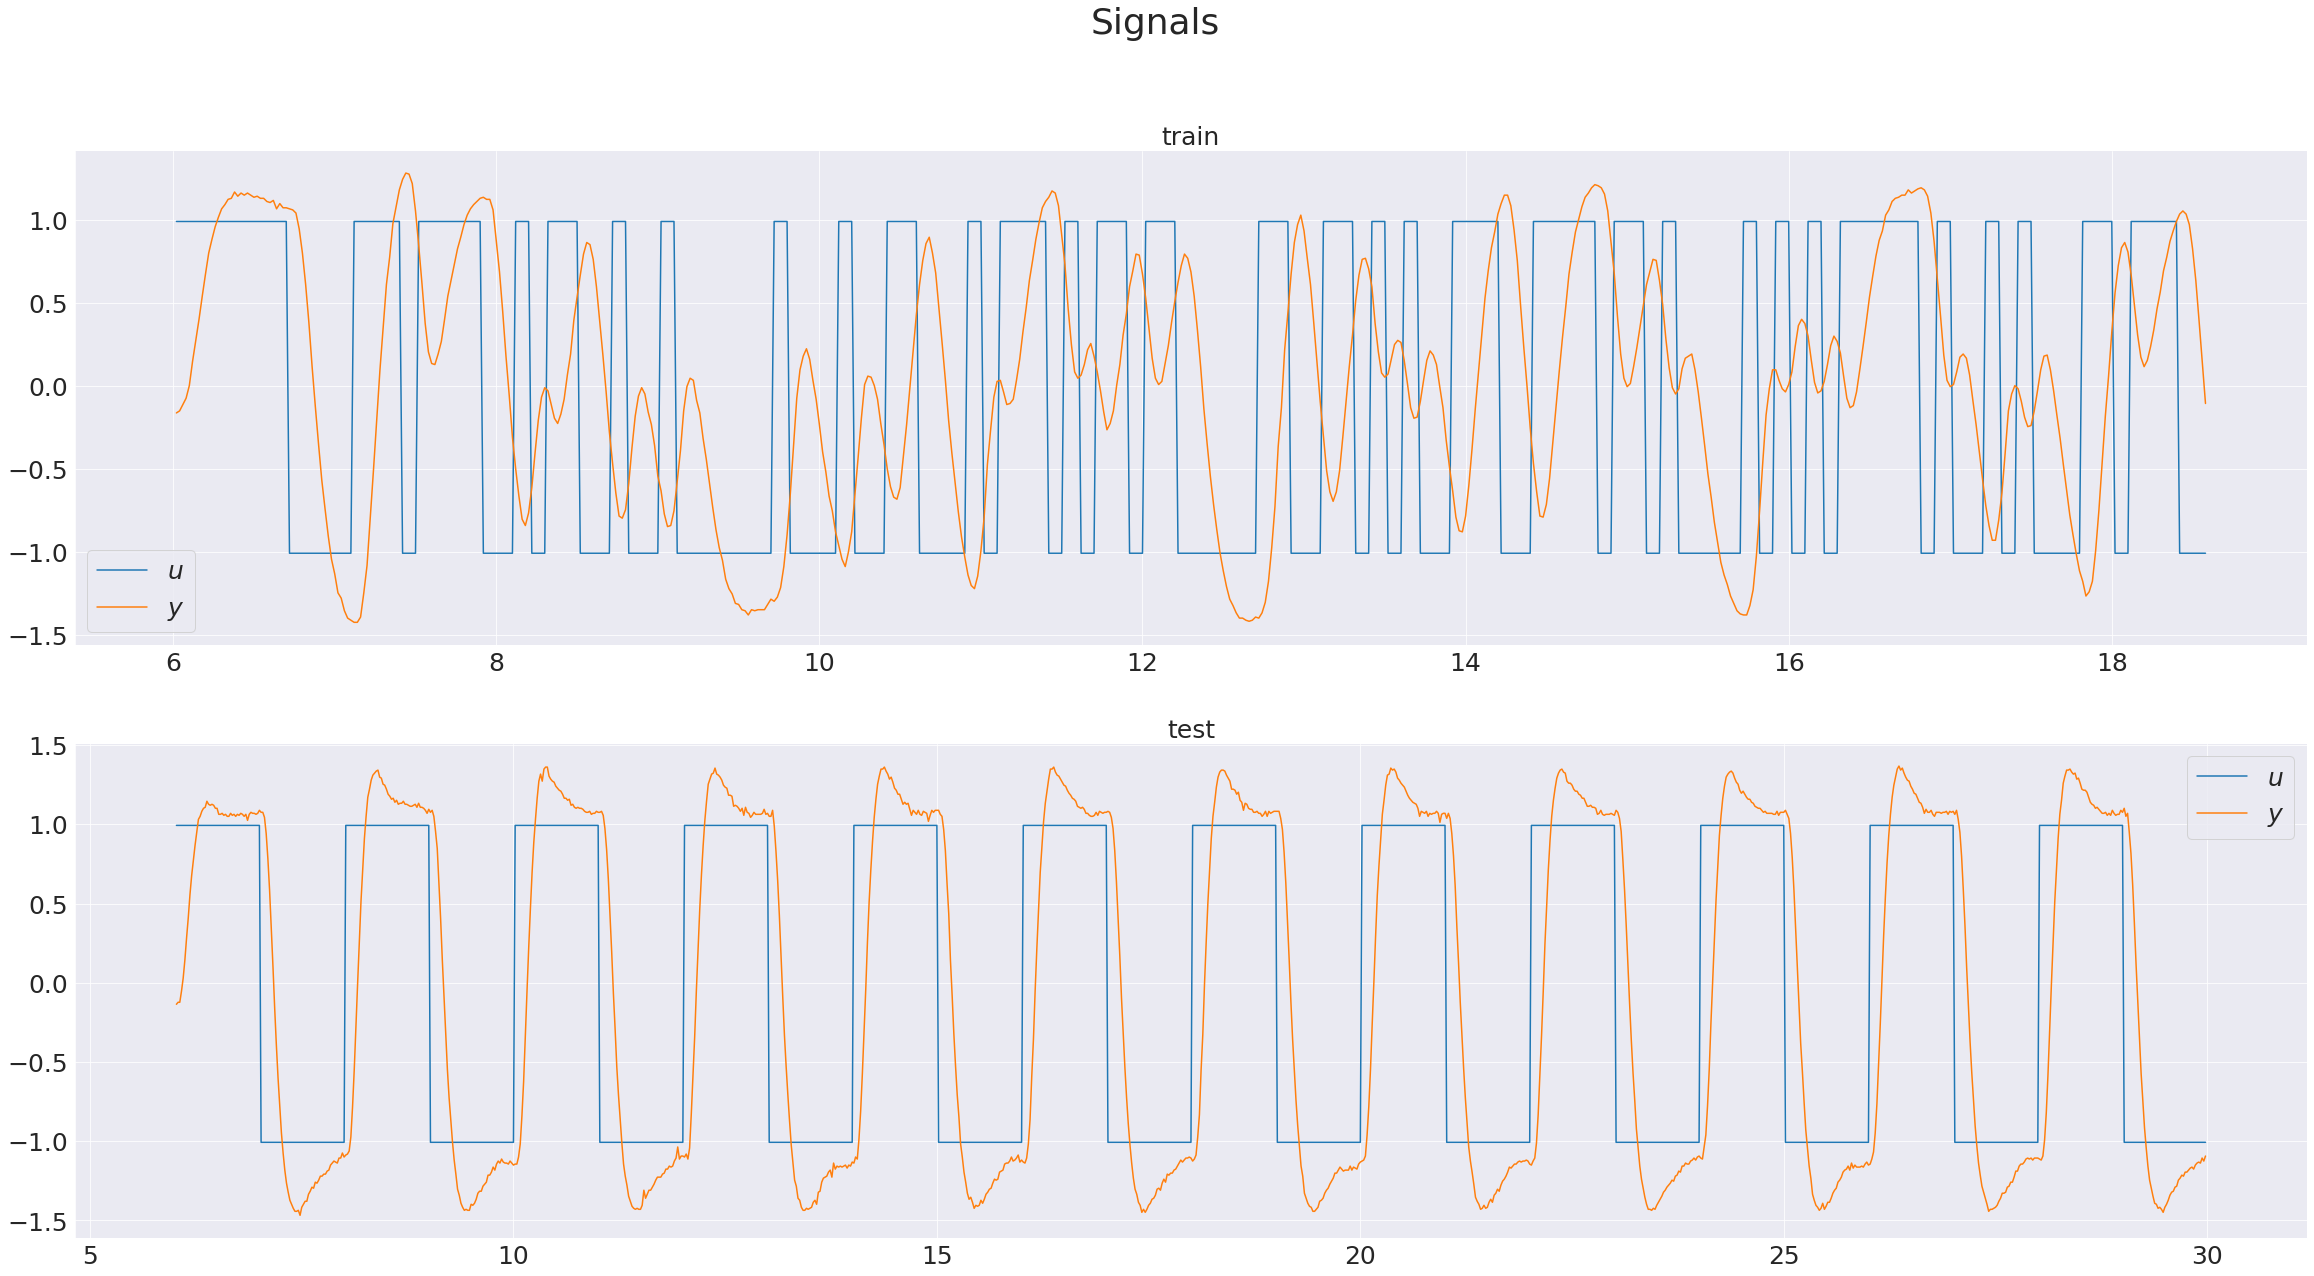

In [15]:
import copy

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from scipy.signal import impulse, lti, step, butter, lfilter, welch
from control import TransferFunction, bode
np.set_printoptions(linewidth=np.inf)

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

u_train = np.asarray(df2['u']).reshape(-1, 1)
u_valid = np.asarray(df1['u']).reshape(-1, 1)
y_train = np.asarray(df2['y']).reshape(-1,1)
y_valid = np.asarray(df1['y']).reshape(-1,1)

fig, axn = plt.subplots(2,1,figsize=(40,20))
title = 'Signals'
fig.suptitle(title)
axn[0].plot(df2['time'], u_train, label=r'$u$')
axn[0].plot(df2['time'], y_train, label=r'$y$')
axn[0].set_title('train')
axn[0].legend()
axn[1].plot(df1['time'], u_valid, label=r'$u$')
axn[1].plot(df1['time'], y_valid, label=r'$y$')
axn[1].set_title('test')
axn[1].legend()
#plt.savefig('figs/{}.eps'.format(title))
plt.show()


# Find the best ARX model, dependent on the test score

In [16]:
ylags = range(2,40)
ulags = range(2,40)

best_mse = 1e6
best_pars = None

for ylag in ylags:
    for ulag in ulags:
        for keep_n_regressors in range(2,ylag+ulag+1):

            lag = max(ulag,ylag)

            model = FROLS(
                ylag=ylag,
                xlag=ulag,
                order_selection=True,
                info_criteria='aic', # Akaike Information Criterion
                n_info_values=keep_n_regressors,
                estimator='least_squares',
                extended_least_squares=False,
                basis_function=Polynomial(degree=1) # linear
            )
            model.fit(X=u_train, y=y_train)

            yhat_train = model._n_step_ahead_prediction(X=u_train, y=y_train[:lag], steps_ahead=len(y_train) - lag)
            yhat_valid = model._n_step_ahead_prediction(X=u_valid, y=y_valid[:lag], steps_ahead=len(y_valid) - lag)

            mse_train = mean_squared_error(y_train[lag:], yhat_train)
            mse_valid = mean_squared_error(y_valid[lag:], yhat_valid)

            if mse_valid < best_mse:
                best_mse = mse_valid
                best_pars = [ylag,ulag,keep_n_regressors]

print(best_mse)
print(best_pars)

/home/kreljo/anaconda3/lib/python3.9/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


0.0033701642856294846
[31, 4, 11]


# Refit and plot

/home/kreljo/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/kreljo/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


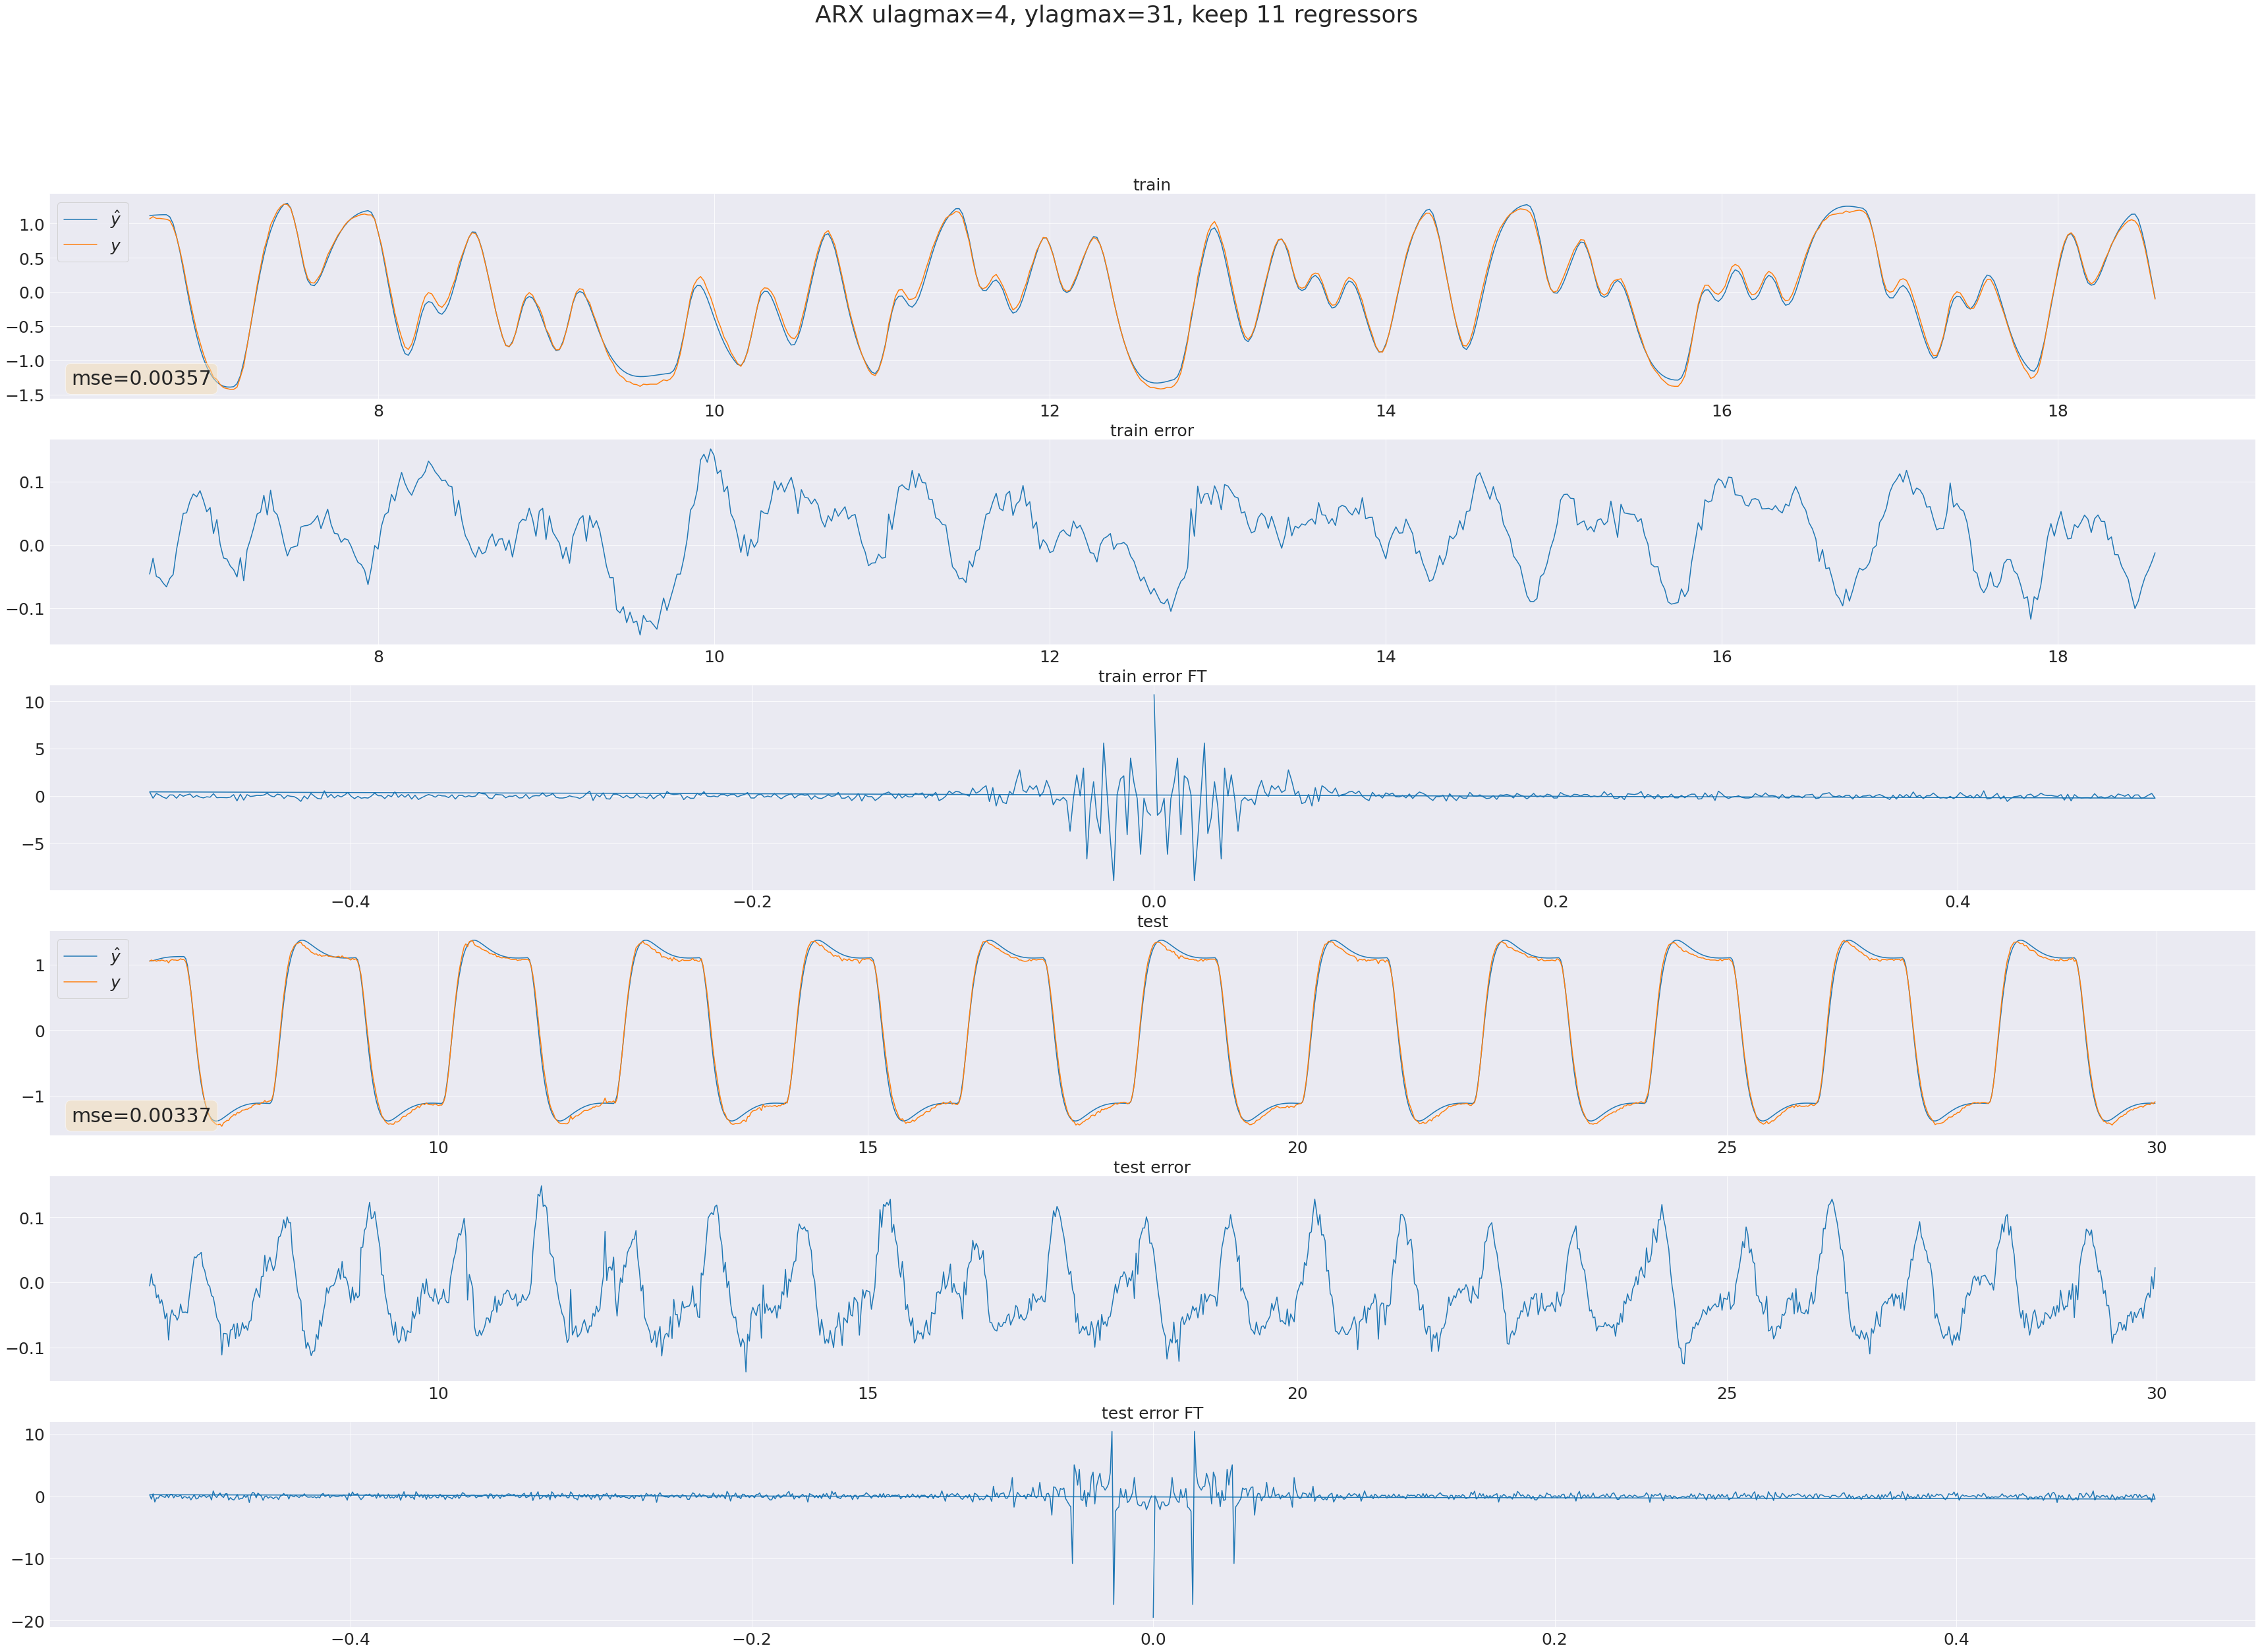

   Regressors   Parameters             ERR
0      y(k-1)   1.0265E+00  9.63838291E-01
1      y(k-2)   3.6697E-01  3.17651227E-02
2     x1(k-3)   3.3613E-02  2.87527918E-03
3     x1(k-4)   3.4736E-02  2.02057206E-04
4      y(k-3)  -2.5074E-01  3.75284803E-04
5     x1(k-2)   1.5857E-02  1.23192065E-04
6      y(k-6)   3.4699E-02  3.98987674E-05
7      y(k-4)  -3.0184E-01  3.39256070E-05
8     y(k-10)  -2.6138E-02  4.24405892E-05
9      y(k-7)   7.7629E-02  7.31973666E-06
10    y(k-23)  -2.0429E-03  4.23603328E-06


In [17]:
ylag = best_pars[0]
ulag = best_pars[1]
lag = max(ulag,ylag)
keep_n_regressors = best_pars[2]

model = FROLS(
    ylag=ylag,
    xlag=ulag,
    order_selection=True,
    info_criteria='aic', # Akaike Information Criterion
    n_info_values=keep_n_regressors,
    estimator='least_squares',
    extended_least_squares=False,
    basis_function=Polynomial(degree=1) # linear
)
model.fit(X=u_train, y=y_train)

yhat_train = model._n_step_ahead_prediction(X=u_train, y=y_train[:lag], steps_ahead=len(y_train) - lag)
yhat_valid = model._n_step_ahead_prediction(X=u_valid, y=y_valid[:lag], steps_ahead=len(y_valid) - lag)

mse_train = mean_squared_error(y_train[lag:], yhat_train)
mse_valid = mean_squared_error(y_valid[lag:], yhat_valid)

fig, axn = plt.subplots(6,1,figsize=(60,40))
title = 'ARX ulagmax={}, ylagmax={}, keep {} regressors'.format(ulag, ylag, keep_n_regressors)
fig.suptitle(title)
axn[0].plot(df2['time'][lag:], yhat_train, label=r'$\hat{y}$')
axn[0].plot(df2['time'][lag:], y_train[lag:], label=r'$y$')
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[1].plot(df2['time'][lag:], y_train[lag:] - yhat_train)
axn[1].set_title('train error')
axn[2].plot(np.fft.fftfreq(len(yhat_train), 1), np.fft.fft((y_train[lag:] - yhat_train).reshape(-1)))
axn[2].set_title('train error FT')
axn[3].plot(df1['time'][lag:], yhat_valid, label=r'$\hat{y}$')
axn[3].plot(df1['time'][lag:], y_valid[lag:], label=r'$y$')
axn[3].set_title('test')
axn[3].legend(loc=2)
axn[3].text(0.01, 0.05, 'mse={}'.format(round(mse_valid,6)), transform=axn[3].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[4].plot(df1['time'][lag:], y_valid[lag:] - yhat_valid)
axn[4].set_title('test error')
axn[5].plot(np.fft.fftfreq(len(yhat_valid), 1), np.fft.fft((y_valid[lag:] - yhat_valid).reshape(-1)))
axn[5].set_title('test error FT')
axn[0].grid(True)
axn[1].grid(True)
axn[2].grid(True)
axn[3].grid(True)
axn[4].grid(True)
axn[5].grid(True)
#plt.savefig('figs/{}.eps'.format(title))
plt.show()

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)